Fast search: use a spatial data structure (e.g., LSH or partition trees) to implement accelerated search at query time. For this, it is best to use an existing library such as annoy or nmslib, and you will need to export the model parameters from Spark to work in your chosen environment. For full credit, you should provide a thorough evaluation of the efficiency gains provided by your spatial data structure over a brute-force search method.

In [1]:
import os
import numpy as np
import pandas as pd
import getpass
import itertools
from glob import glob
import time
import datetime

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import collect_list
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
import matplotlib.pyplot as plt

from annoy import AnnoyIndex
from tqdm import tqdm_notebook as tqdm

In [2]:
#Set up Spark locally
builder = SparkSession.builder
builder = builder.config("spark.executor.memory", "6G")
builder = builder.config("spark.driver.memory", "10G")
builder = builder.config("spark.driver.maxResultSize", "6G")
spark = builder.appName("Master").getOrCreate()

### Load train and validation

In [3]:
#'/scratch/work/courses/DSGA1004-2021/MSD/cf_validation.parquet'
#'/scratch/work/courses/DSGA1004-2021/MSD/cf_train.parquet'
#'/home/yw5260/final-project-team_into4/cf_test.parquet'

In [4]:
#Read from local parquet files (downloaded from the path above)
train = spark.read.parquet('train.parquet')
validation = spark.read.parquet('val.parquet')

train.createOrReplaceTempView('train')
validation.createOrReplaceTempView('validation')

In [5]:
spark.sql('SELECT COUNT(DISTINCT user_id) FROM train').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1129318|
+-----------------------+



In [6]:
spark.sql('SELECT COUNT(DISTINCT user_id) FROM validation').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                  10000|
+-----------------------+



In [7]:
#Option 1, use a random sample from train
uniq_val = spark.sql('SELECT DISTINCT (user_id) FROM validation')
uniq_val.createOrReplaceTempView('uniq_val')

df = train.sample(False, 0.25, 42)
df.createOrReplaceTempView('df')
df_val = spark.sql('SELECT df.user_id, df.count, df.track_id FROM df INNER JOIN uniq_val ON df.user_id = uniq_val.user_id')
df_val.createOrReplaceTempView('df_val')

print('The number of distinct users from this train sample that also show up in validation')
spark.sql('SELECT COUNT(DISTINCT user_id) FROM df_val').show()

The number of distinct users from this train sample that also show up in validation
+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                   9194|
+-----------------------+



In [8]:
#Option 2, select all rows for users that show up in both train and validation
uniq_val = spark.sql('SELECT DISTINCT (user_id) FROM validation')
uniq_val.createOrReplaceTempView('uniq_val')

df = spark.sql('SELECT train.user_id, train.count, train.track_id FROM train INNER JOIN uniq_val ON train.user_id = uniq_val.user_id')
df.createOrReplaceTempView('df')

print('The number of distinct users that show up in both train and validation')
spark.sql('SELECT COUNT(DISTINCT user_id) FROM df').show()

The number of distinct users that show up in both train and validation
+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                  10000|
+-----------------------+



In [9]:
indexers = [StringIndexer(inputCol=column, outputCol= 'indexed_' + column).setHandleInvalid('skip') for column in list(set(df.columns)-set(['count','__index_level_0__']))]
    
pipeline = Pipeline(stages=indexers)
indexer_transform = pipeline.fit(df)
    
df = indexer_transform.transform(df)
validation = indexer_transform.transform(validation)

In [11]:
user_validation = validation.select('indexed_user_id').distinct()
group_item = validation.select('indexed_user_id', 'indexed_track_id').groupBy('indexed_user_id')
true_item = group_item.agg(collect_list('indexed_track_id').alias('true_track'))

### Train ALS model using parameters combo from tuning
### (Use option 2 for downsampling)

In [12]:
rank = [200]  
reg_params = [1]  
alpha = [10]     
param_choice = itertools.product(rank, reg_params, alpha)

In [13]:
for i in param_choice:
    als = ALS(rank = i[0], 
              maxIter = 10, 
              regParam = i[1], 
              userCol = 'indexed_user_id',
              itemCol = 'indexed_track_id',
              ratingCol = 'count', 
              implicitPrefs = True, 
              alpha = i[2],
              nonnegative=False,
              coldStartStrategy='drop')
        
    model = als.fit(df)

In [14]:
#Extract user factors and item factors
user_factor = model.userFactors
item_factor = model.itemFactors
user_df = user_factor.toPandas()
item_df = item_factor.toPandas()

In [15]:
item_df

,id,features
0,0,"[0.09963960200548172, -0.12049102783203125, -0..."
1,10,"[0.19621501863002777, 0.18064600229263306, -0...."
2,20,"[0.17178677022457123, 0.14573657512664795, -0...."
3,30,"[0.246071919798851, -0.011734317988157272, -0...."
4,40,"[-0.03892082720994949, 0.16944539546966553, -0..."
...,...,...
49023,48979,"[-0.0012484464095905423, 0.0008200528682209551..."
49024,48989,"[0.05154109001159668, 0.07747381180524826, 0.0..."
49025,48999,"[0.00016529456479474902, -0.020128844305872917..."
49026,49009,"[0.004265699069947004, -0.009092509746551514, ..."


In [16]:
user_df

,id,features
0,0,"[-0.17346660792827606, 0.057663943618535995, -..."
1,10,"[0.09907369315624237, 0.01952333375811577, -0...."
2,20,"[-0.020480383187532425, 0.051797594875097275, ..."
3,30,"[0.0829821303486824, 0.08336185663938522, -0.1..."
4,40,"[0.033947352319955826, 0.04258722439408302, 0...."
...,...,...
9995,9959,"[-0.02258901298046112, -0.060730062425136566, ..."
9996,9969,"[-0.025184469297528267, -0.009386678226292133,..."
9997,9979,"[0.015737343579530716, -0.013592570088803768, ..."
9998,9989,"[0.04540069401264191, 0.042910147458314896, -0..."


### Annoy data pre-processing

In [19]:
user_validation = validation.select(validation['indexed_user_id'].alias('id')).distinct()
mutual = user_validation.join(user_factor,'id','inner')
mutual = mutual.toPandas()

In [20]:
tracks = np.array(list(item_df['features']))
np.shape(tracks)

(49028, 200)

In [21]:
queries = np.array(list(mutual['features']))
np.shape(queries)

(9973, 200)

### Brute Force Search vs. Fast Search

In [22]:
def brute_force_timed(query):
    start = time.time()
    dot_product = tracks.dot(query)
    indices = np.argsort(dot_product)[::-1][:500]
    end = time.time() - start
    return end, indices

In [23]:
def annoy_timed(query, sk):
    start = time.time()
    indices = t.get_nns_by_vector(query, n=nn, search_k=sk, include_distances=False)   
    end = time.time() - start
    return end, indices

In [24]:
def precision_recall(ann, truth):
    intersect = [i for i in ann if i in truth]
    intersect_len = len(intersect)
    precision = intersect_len/len(ann)
    recall = intersect_len/len(truth)
    return precision, recall

In [25]:
def map_score(ann, bf):
    all_p = []
    for i in range(len(ann)):
        both = list(set(ann[i]) & set(bf[i]))
        count = 0
        pre = 0
        for j in range(len(ann[i])):
            if ann[i][j] in both:
                count += 1
                pre += count/(j+1)
        all_p.append(pre)
    
    return np.mean(all_p)

In [26]:
#Initialize parameters
f = len(tracks[0]) #rank = 200
n_queries = len(queries)
nn = 500 

n_trees = [10, 20, 40]  
search_k = [1000, 5000, 10000, 50000, 100000]     
param_choice = itertools.product(n_trees, search_k)

In [27]:
#Brute force
all_time = []
all_results = []
for q in tqdm(range(n_queries)):
    end, indices = brute_force_timed(queries[q])
    all_time.append(end)
    all_results.append(indices)
    mean_time = np.mean(all_time)
        
print(f'Max time for brute-force search: {max(all_time)}')
print(f'Min time for brute-force search: {min(all_time)}')
print(f'Mean time for brute-force search: {mean_time}')

<ipython-input-27-26609dbbbbe8>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for q in tqdm(range(n_queries)):



Max time for brute-force search: 0.024167776107788086
Min time for brute-force search: 0.0047872066497802734
Mean time for brute-force search: 0.005670611889207183


In [28]:
max_time_ann={}
mean_time_ann={}
pre_dict={}
recall_dict={}

for i in param_choice:
    
    #Build annoy tree
    t = AnnoyIndex(f, 'dot')
    for j in range(len(tracks)):
        t.add_item(j, tracks[j])
    t.build(i[0])
    #t.save(f'tree_{i[0]}_{i[1]}.ann')    
        
    
    #Annoy
    all_time_ann = []
    all_results_ann = []
    for q in tqdm(range(n_queries)):
        end, indices = annoy_timed(queries[q], i[1])
        all_time_ann.append(end)
        all_results_ann.append(indices)
        mean_time = np.mean(all_time_ann)
    
    max_time_ann[(i[0], i[1])] = max(all_time_ann)
    mean_time_ann[(i[0], i[1])] = mean_time
    
    print(f'n_trees = {i[0]}, search_k = {i[1]}')          
    print(f'Max time for annoy search: {max(all_time_ann)}')
    print(f'Min time for annoy search: {min(all_time_ann)}')
    print(f'Mean time for annoy search: {mean_time}')
    
    
    #Precision and recall
    pres = []
    recalls = []
    for q in range(n_queries):
        p, r = precision_recall(all_results_ann[q], all_results[q])
        pres.append(p)
        recalls.append(r)
      
    pre_dict[(i[0], i[1])] = np.mean(pres)
    recall_dict[(i[0], i[1])] = np.mean(recalls)
    
    print()
    print(f'Max precision: {np.max(pres)}')
    print(f'Min precsion: {np.min(pres)}')
    print(f'Mean precision: {np.mean(pres)}')    
    #print(f'MAP score: {map_score(all_results_ann, all_results)}')

<ipython-input-28-9aa82677288f>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for q in tqdm(range(n_queries)):



n_trees = 10, search_k = 1000
Max time for annoy search: 0.005475282669067383
Min time for annoy search: 0.00021004676818847656
Mean time for annoy search: 0.00034909904343809585

Max precision: 0.61
Min precsion: 0.0
Mean precision: 0.12063513478261226



n_trees = 10, search_k = 5000
Max time for annoy search: 0.002238035202026367
Min time for annoy search: 0.0009729862213134766
Mean time for annoy search: 0.001236615156584705

Max precision: 0.816
Min precsion: 0.016
Mean precision: 0.2952999097563421



n_trees = 10, search_k = 10000
Max time for annoy search: 0.003582000732421875
Min time for annoy search: 0.0018129348754882812
Mean time for annoy search: 0.0021403327361638265

Max precision: 0.88
Min precsion: 0.03
Mean precision: 0.4265575052642134



n_trees = 10, search_k = 50000
Max time for annoy search: 0.007934093475341797
Min time for annoy search: 0.005700111389160156
Mean time for annoy search: 0.006127336660431223

Max precision: 0.974
Min precsion: 0.332
Mean precision: 0.8355168956181691



n_trees = 10, search_k = 100000
Max time for annoy search: 0.011034011840820312
Min time for annoy search: 0.009238004684448242
Mean time for annoy search: 0.009770882807415776

Max precision: 1.0
Min precsion: 0.552
Mean precision: 0.9585502857715834



n_trees = 20, search_k = 1000
Max time for annoy search: 0.0007238388061523438
Min time for annoy search: 0.00021576881408691406
Mean time for annoy search: 0.0003450569245397632

Max precision: 0.664
Min precsion: 0.0
Mean precision: 0.13800985351097939



n_trees = 20, search_k = 5000
Max time for annoy search: 0.0023050308227539062
Min time for annoy search: 0.0008380413055419922
Mean time for annoy search: 0.001234416125901996

Max precision: 0.88
Min precsion: 0.01
Mean precision: 0.3302631103980748



n_trees = 20, search_k = 10000
Max time for annoy search: 0.004617214202880859
Min time for annoy search: 0.0017290115356445312
Mean time for annoy search: 0.0021471095326598736

Max precision: 0.928
Min precsion: 0.034
Mean precision: 0.4671882081620375



n_trees = 20, search_k = 50000
Max time for annoy search: 0.009512186050415039
Min time for annoy search: 0.00559687614440918
Mean time for annoy search: 0.006126652889429572

Max precision: 0.992
Min precsion: 0.284
Mean precision: 0.8575459741301514



n_trees = 20, search_k = 100000
Max time for annoy search: 0.014257192611694336
Min time for annoy search: 0.009055137634277344
Mean time for annoy search: 0.00979241085999184

Max precision: 1.0
Min precsion: 0.524
Mean precision: 0.9630500350947558



n_trees = 40, search_k = 1000
Max time for annoy search: 0.0013971328735351562
Min time for annoy search: 0.00021409988403320312
Mean time for annoy search: 0.0003782703562604261

Max precision: 0.716
Min precsion: 0.0
Mean precision: 0.1544685942626253



n_trees = 40, search_k = 5000
Max time for annoy search: 0.00315093994140625
Min time for annoy search: 0.0008139610290527344
Mean time for annoy search: 0.0013498542995638394

Max precision: 0.904
Min precsion: 0.008
Mean precision: 0.3632896821417828



n_trees = 40, search_k = 10000
Max time for annoy search: 0.004102945327758789
Min time for annoy search: 0.001535177230834961
Mean time for annoy search: 0.0022957614010128374

Max precision: 0.966
Min precsion: 0.034
Mean precision: 0.5066194725759551



n_trees = 40, search_k = 50000
Max time for annoy search: 0.009292125701904297
Min time for annoy search: 0.005464076995849609
Mean time for annoy search: 0.006149244131564281

Max precision: 0.998
Min precsion: 0.188
Mean precision: 0.8785119823523513



n_trees = 40, search_k = 100000
Max time for annoy search: 0.01954793930053711
Min time for annoy search: 0.00884699821472168
Mean time for annoy search: 0.00988248981229881

Max precision: 1.0
Min precsion: 0.43
Mean precision: 0.968604833049233


### Visualization

In [29]:
mean_time_ann_lst = list(mean_time_ann.values())
max_time_ann_lst = list(max_time_ann.values())
precision_dict_lst = list(pre_dict.values())
recall_dict_lst = list(recall_dict.values())

In [30]:
tree_key = [list(mean_time_ann.keys())[i][0] for i in range(len(mean_time_ann))]
k_key = [list(mean_time_ann.keys())[i][1] for i in range(len(mean_time_ann))]

In [31]:
vis = pd.DataFrame({'mean_time_ann':mean_time_ann_lst, 'max_time_ann':max_time_ann_lst, 'mean_precision':precision_dict_lst,
                       'mean_recall':recall_dict_lst, 'n_trees':tree_key, 'search_k':k_key})
vis['mean_time_bf'] = np.mean(all_time)
vis

,mean_time_ann,max_time_ann,mean_precision,mean_recall,n_trees,search_k,mean_time_bf
0,0.000349,0.005475,0.120635,0.120635,10,1000,0.005671
1,0.001237,0.002238,0.295300,0.295300,10,5000,0.005671
2,0.002140,0.003582,0.426558,0.426558,10,10000,0.005671
3,0.006127,0.007934,0.835517,0.835517,10,50000,0.005671
4,0.009771,0.011034,0.958550,0.958550,10,100000,0.005671
5,0.000345,0.000724,0.138010,0.138010,20,1000,0.005671
6,0.001234,0.002305,0.330263,0.330263,20,5000,0.005671
7,0.002147,0.004617,0.467188,0.467188,20,10000,0.005671
8,0.006127,0.009512,0.857546,0.857546,20,50000,0.005671
9,0.009792,0.014257,0.963050,0.963050,20,100000,0.005671


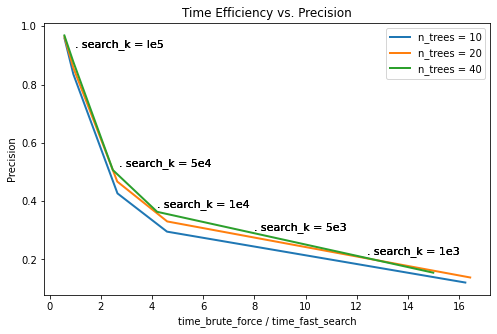

In [32]:
fig, ax = plt.subplots(figsize = (8,5))
groups = vis.groupby('n_trees')
groupk = vis.groupby('search_k')

for n, group in groups:
    eff = group.mean_time_bf/group.mean_time_ann
    plt.plot(eff, group.mean_recall, linestyle='-', linewidth=2, label=(f'n_trees = {n}'))
    plt.text(1, 0.93, ". search_k = le5", size = 11, transform=ax.transData)
    plt.text(2.7, 0.52, ". search_k = 5e4", size = 11, transform=ax.transData)
    plt.text(4.2, 0.38, ". search_k = 1e4", size = 11, transform=ax.transData)
    plt.text(8, 0.3, ". search_k = 5e3", size = 11, transform=ax.transData)
    plt.text(12.4, 0.22, ". search_k = 1e3", size = 11, transform=ax.transData)

plt.xlabel('time_brute_force / time_fast_search')
plt.ylabel('Precision')
plt.title('Time Efficiency vs. Precision')
plt.legend()
plt.show()